In [1]:
from pandas import read_csv, unique

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from scipy.stats import mode

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from tensorflow import stack
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from keras.layers import Conv1D, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('C:/Users/USER/Desktop/AI_Study/dataset/paperwork/02-14-2018.csv')
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [3]:
df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [4]:
df.count()

Dst Port         1048575
Protocol         1048575
Timestamp        1048575
Flow Duration    1048575
Tot Fwd Pkts     1048575
                  ...   
Idle Mean        1048575
Idle Std         1048575
Idle Max         1048575
Idle Min         1048575
Label            1048575
Length: 80, dtype: int64

Text(0.5, 1.0, 'Label')

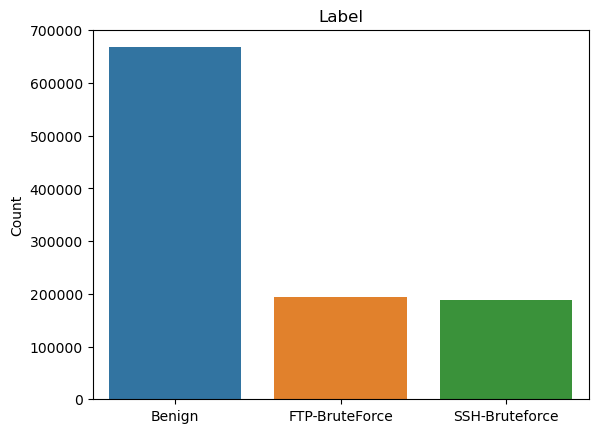

In [5]:
sns.countplot(data = df, x="Label")
plt.xlabel("")
plt.ylabel("Count")
plt.title("Label")

In [6]:
df['Label'].value_counts()

Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
Name: count, dtype: int64

In [7]:
label_encode = LabelEncoder()
df['Timestamp'] = label_encode.fit_transform(df['Timestamp'].values.ravel())
df['Label'] = label_encode.fit_transform(df['Label'].values.ravel())
df

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,15905,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,0
1,0,0,16074,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,0
2,0,0,16243,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,0
3,22,6,16457,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,0
4,22,6,16467,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,24447,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,0
1048571,80,6,24457,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,0
1048572,80,6,24452,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,0
1048573,80,6,24452,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,0


In [8]:
dfX = df.drop('Label', axis=1)
dfX.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0,0,15905,112641719,3,0,0,0,0,0,...,0,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761
1,0,0,16074,112641466,3,0,0,0,0,0,...,0,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652
2,0,0,16243,112638623,3,0,0,0,0,0,...,0,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098
3,22,6,16457,6453966,15,10,1239,2273,744,0,...,6,32,0.0,0.0,0,0,0.0,0.000000,0,0
4,22,6,16467,8804066,14,11,1143,2209,744,0,...,6,32,0.0,0.0,0,0,0.0,0.000000,0,0


In [9]:
def MinMaxScaler(data):
    """최솟값과 최댓값을 이용하여 0 ~ 1 값으로 변환"""
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # 0으로 나누기 에러가 발생하지 않도록 매우 작은 값(1e-7)을 더해서 나눔
    return numerator / (denominator + 1e-7)

In [10]:
dfX = MinMaxScaler(dfX)
dfX

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
0,0.000000,0.000000,0.496380,0.999992,0.000391,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000166,5.726192e-10,0.000057,0.004469
1,0.000000,0.000000,0.501654,0.999992,0.000391,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000166,4.708848e-10,0.000057,0.004469
2,0.000000,0.000000,0.506928,0.999992,0.000391,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.000166,1.241159e-09,0.000057,0.004469
3,0.000336,0.352941,0.513607,0.999876,0.002738,0.001087,0.000144,0.000170,0.011546,0.0,...,0.00582,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
4,0.000336,0.352941,0.513919,0.999879,0.002542,0.001196,0.000133,0.000165,0.011546,0.0,...,0.00582,0.666667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,0.001221,0.352941,0.762967,0.999880,0.000782,0.000544,0.000127,0.000144,0.009109,0.0,...,0.00194,0.416667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1048571,0.001221,0.352941,0.763279,0.999869,0.000196,0.000000,0.000000,0.000000,0.000000,0.0,...,0.00000,0.416667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1048572,0.001221,0.352941,0.763123,0.999875,0.000391,0.000109,0.000000,0.000000,0.000000,0.0,...,0.00000,0.416667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
1048573,0.001221,0.352941,0.763123,0.999875,0.000391,0.000109,0.000000,0.000000,0.000000,0.0,...,0.00000,0.416667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000


In [11]:
dfy = df['Label']
dfy

0          0
1          0
2          0
3          0
4          0
          ..
1048570    0
1048571    0
1048572    0
1048573    0
1048574    0
Name: Label, Length: 1048575, dtype: int32

In [12]:
X = dfX.values.tolist()
y = dfy.values.tolist()

In [13]:
window_size = 100

data_X = []
data_y = []
for i in range(0, len(y) - window_size, 20):
    _X = X[i : i + window_size]
    _y = y[i + window_size]
    data_X.append(_X)
    data_y.append(_y)

In [14]:
print('전체 데이터의 크기 :', len(data_X), len(data_y))

전체 데이터의 크기 : 52424 52424


In [15]:
train_size = int(len(data_y) * 0.7)
X_train = np.array(data_X[0 : train_size])
y_train = np.array(data_y[0 : train_size])

test_size = len(data_y) - train_size
X_test = np.array(data_X[train_size : len(data_X)])
y_test = np.array(data_y[train_size : len(data_y)])

print('훈련 데이터의 크기 :', X_train.shape, y_train.shape)
print('테스트 데이터의 크기 :', X_test.shape, y_test.shape)

훈련 데이터의 크기 : (36696, 100, 79) (36696,)
테스트 데이터의 크기 : (15728, 100, 79) (15728,)


In [16]:
y_train_onehot = pd.get_dummies(y_train).values
y_test_onehot = pd.get_dummies(y_test).values

In [17]:
print(X_train.shape, y_train_onehot.shape)
print(X_test.shape, y_test_onehot.shape)

(36696, 100, 79) (36696, 3)
(15728, 100, 79) (15728, 1)


In [18]:
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_onehot.shape[1]
print(n_timesteps, n_features, n_outputs)

100 79 3


In [19]:
model = Sequential()
model.add(LSTM(units = 20, input_shape = [n_timesteps, n_features], activation = "relu"))
model.add(Dropout(0.3))
model.add(Dense(units = 20, activation = "relu"))
model.add(Dense(n_outputs, activation = "softmax"))

In [20]:
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                8000      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense (Dense)               (None, 20)                420       
                                                                 
 dense_1 (Dense)             (None, 3)                 63        
                                                                 
Total params: 8483 (33.14 KB)
Trainable params: 8483 (33.14 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
history = model.fit(X_train, y_train_onehot, epochs=30, validation_split = 0.1, verbose=True)

Epoch 1/30


1033/1033 [==============================] - 32s 29ms/step - loss: 1.0835 - accuracy: 0.4230 - val_loss: 0.8614 - val_accuracy: 1.0000
Epoch 2/30
1033/1033 [==============================] - 27s 27ms/step - loss: 1.0812 - accuracy: 0.4231 - val_loss: 0.8592 - val_accuracy: 1.0000
Epoch 3/30
1033/1033 [==============================] - 28s 27ms/step - loss: 1.0811 - accuracy: 0.4231 - val_loss: 0.8715 - val_accuracy: 1.0000
Epoch 4/30
1033/1033 [==============================] - 28s 27ms/step - loss: 1.0811 - accuracy: 0.4231 - val_loss: 0.8474 - val_accuracy: 1.0000
Epoch 5/30
1033/1033 [==============================] - 31s 30ms/step - loss: 1.0812 - accuracy: 0.4231 - val_loss: 0.8687 - val_accuracy: 1.0000
Epoch 6/30
1033/1033 [==============================] - 29s 29ms/step - loss: 1.0812 - accuracy: 0.4231 - val_loss: 0.8565 - val_accuracy: 1.0000
Epoch 7/30
1033/1033 [==============================] - 29s 28ms/step - loss: 1.0812 - accuracy: 0.4231 - val_loss: 0.8587

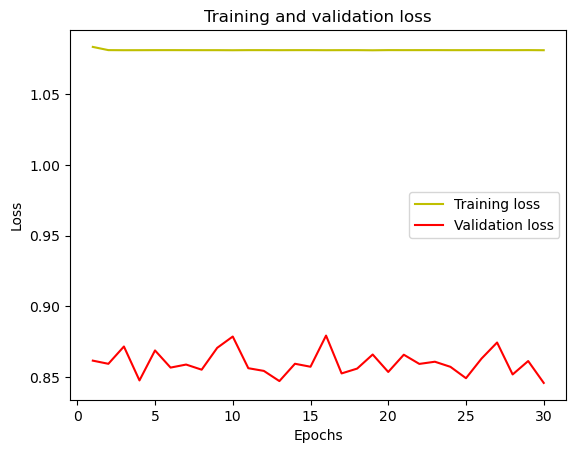

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

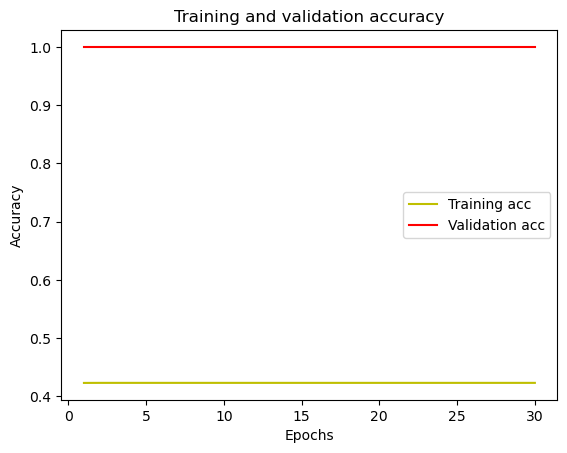

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix


y_pred = model.predict(X_test)
y_test_class = np.argmax(y_test_onehot,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

492/492 [==============================] - 4s 8ms/step


In [25]:
#Accuracy of the predicted values
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))
print(confusion_matrix(y_test_class,y_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15728

    accuracy                           1.00     15728
   macro avg       1.00      1.00      1.00     15728
weighted avg       1.00      1.00      1.00     15728

[[15728]]
